In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=e7c2e24053e6b5491e50929d92de483f757f81ac917ea26c5f429962eec6e290
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import torch
import numpy as np
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm
import matplotlib.pyplot as plt
import imutils
import cv2
import PIL.Image
import os


In [13]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

def process_and_augment_images(input_dir, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define augmentation pipeline
    transform = A.Compose([
        A.Rotate(limit=15, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(),
    ])

    # Process and augment images
    for img_name in tqdm(os.listdir(input_dir)):
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert to grayscale and apply Gaussian blur
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Thresholding, erosion, and dilation
        thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours and extract extreme points
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Crop image based on extreme points
        cropped_img = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

        # Apply augmentation to cropped image
        augmented_images = [transform(image=cropped_img)['image'] for _ in range(20)]

        # Save augmented images to output directory
        for i, augmented_img in enumerate(augmented_images):
            output_path = os.path.join(output_dir, f"{img_name[:-4]}_{i}.jpg")
            cv2.imwrite(output_path, augmented_img)


In [8]:
def process_images(input_dir, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)

        # Convert to grayscale and apply Gaussian blur
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Find contours and extract extreme points
        _, thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)

        # Crop image based on bounding box
        cropped_img = image[y:y+h, x:x+w]

        # Save cropped image
        output_path = os.path.join(output_dir, img_name)
        cv2.imwrite(output_path, cropped_img)


In [9]:
input_folder_list = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

In [15]:
for input_folder in input_folder_list :
  process_and_augment_images(f'/kaggle/input/brain-tumor-classification-mri/Training/{input_folder}',f'/kaggle/working/Augmentation_Train/{input_folder}' )



100%|██████████| 827/827 [01:59<00:00,  6.91it/s]


In [16]:
for input_folder in input_folder_list :
  process_images(f'/kaggle/input/brain-tumor-classification-mri/Testing/{input_folder}',f'/kaggle/working/Augmentation_Test/{input_folder}' )



In [8]:
#Transforms
transformer_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                        [0.5,0.5,0.5])
])

transformer_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                        [0.5,0.5,0.5])
])


In [9]:
train_path = '/kaggle/input/brain-tumor-classification-mri/Training'
test_path = '/kaggle/input/brain-tumor-classification-mri/Testing'

In [10]:
#Data Loader
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform = transformer_train),
    batch_size = 128, shuffle = True
)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform = transformer_test),
    batch_size = 128, shuffle = True
)

In [11]:
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [12]:
print(classes)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [13]:
class ConvoNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvoNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,224,224)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,224,224)
        self.bn1=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,224,224)
        self.relu1=nn.ELU()
        #Shape= (256,32,224,224)

        self.pool1=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,32,112,112)


        self.conv2=nn.Conv2d(in_channels=32,out_channels=50,kernel_size=3,stride=1,padding=1)
        #Shape= (256,50,112,112)
        self.bn2=nn.BatchNorm2d(num_features=50)
        self.relu2=nn.ELU()
        #Shape= (256,50,112,112)

        self.pool2=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,50,56,56)


        self.conv3=nn.Conv2d(in_channels=50,out_channels=128,kernel_size=3,stride=1,padding=1)
        #Shape= (256,128,56,56)
        self.bn3=nn.BatchNorm2d(num_features=128)
        #Shape= (256,128,56,56)
        self.relu3=nn.ELU()
        #Shape= (256,128,56,56)

        self.pool3=nn.MaxPool2d(kernel_size=2)

        self.fc1=nn.Linear(in_features=28 * 28 * 128,out_features=1024)
        self.fc2=nn.Linear(in_features = 1024,out_features=256)
        self.fc3=nn.Linear(in_features = 256,out_features=128)
        self.fc4=nn.Linear(in_features = 128,out_features=32)
        self.fc5=nn.Linear(in_features=32,out_features=num_classes)



        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool1(output)

        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)

        output=self.pool2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        output=self.pool3(output)



        #Above output will be in matrix form, with shape (256,32,56,56)

        output=output.view(-1,128*28*28)


        output=self.fc1(output)
        output=self.fc2(output)
        output=self.fc3(output)
        output=self.fc4(output)
        output=self.fc5(output)

        return output

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = ConvoNet(num_classes =4).to(device)

In [16]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.001)
loss_function=nn.CrossEntropyLoss()

In [17]:
import glob
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [18]:
epochs = 5

In [19]:
from tqdm import tqdm

best_accuracy = 0.0

for epoch in range(epochs):

    #Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    # Create a progress bar for training
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

    for i, (images, labels) in enumerate(train_bar):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().item() * images.size(0)  
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += torch.sum(prediction == labels.data).item()

        # Update the progress bar with current loss and accuracy
        train_bar.set_postfix(train_loss=train_loss, train_accuracy=train_accuracy)

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count


    # Evaluation on testing dataset
    model.eval()

    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += torch.sum(prediction == labels.data).item()

    test_accuracy = test_accuracy / test_count


    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy


Epoch: 0 Train Loss: 15.983222500870868 Train Accuracy: 0.4236933797909408 Test Accuracy: 0.23604060913705585


Epoch: 1 Train Loss: 1.3034797779774416 Train Accuracy: 0.6310104529616725 Test Accuracy: 0.3020304568527919


Epoch: 2 Train Loss: 0.6667613693646022 Train Accuracy: 0.7240418118466899 Test Accuracy: 0.38071065989847713


Epoch: 3 Train Loss: 0.5908002811441854 Train Accuracy: 0.7536585365853659 Test Accuracy: 0.38578680203045684


Epoch: 4 Train Loss: 0.5639231678916187 Train Accuracy: 0.7707317073170732 Test Accuracy: 0.4086294416243655


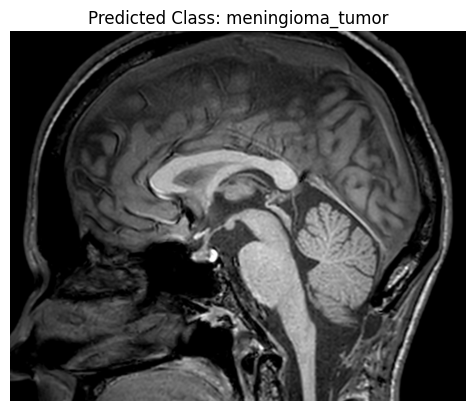

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

# Load the model
model = ConvoNet(num_classes=4)
model.load_state_dict(torch.load('best_checkpoint.model'))
model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match input size of the model
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Function to predict class labels
def predict_image(image_path):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Upload and validate a picture
uploaded_image_path = '/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (23).jpg'  
predicted_class = predict_image(uploaded_image_path)

if predicted_class == 1:
  classification = 'glioma_tumor'
elif predicted_class == 2:
  classification = 'meningioma_tumor'
elif predicted_class == 3: 
  classification = 'no_tumor'
else:
  classification = 'pituitary_tumor'


# Display the uploaded picture and predicted class label
image = Image.open(uploaded_image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted Class: {classification}')
plt.show()

In [24]:
torch.save(model.state_dict(), 'braintumor.pth')

In [30]:
from flask import Flask, request, jsonify
from PIL import Image
import torch
import torchvision.transforms as transforms

app = Flask(__name__)

# Load the model
model = ConvoNet(num_classes=4)
model.load_state_dict(torch.load('best_checkpoint.model'))
model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match input size of the model
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Function to predict class labels
def predict_image(image):
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    return predicted.item()

@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image found in request'}), 400
    
    uploaded_image = request.files['image']
    image = Image.open(uploaded_image)
    predicted_class = predict_image(image)

    if predicted_class == 0:
        classification = 'glioma_tumor'
    elif predicted_class == 1:
        classification = 'meningioma_tumor'
    elif predicted_class == 2: 
        classification = 'no_tumor'
    else:
        classification = 'pituitary_tumor'

    return jsonify({'predicted_class': classification}), 200

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1042, in launch_instance
    app.initialize(argv)
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 113, in inner
    return method(app, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 654, in initialize
    self.init_sockets()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 331, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/opt/conda/lib/python3.10/site-packages/

SystemExit: 1

  adding: kaggle/working/braintumor.pth (deflated 7%)
